# Volume 4: Optimal Control as Boundary Value Problems
    Daniel Perkins
    MATH 439
    1/30/25

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

## Problem 1
Given the following cost functional and boundary conditions, solve for and plot the optimal path and acceleration.
\begin{align*}
    J(u) &= \int_0^{30} x^2 + \frac{2\pi}{5}u^2dt \\
    s(t) &= \begin{bmatrix}x(t)\\x'(t) \end{bmatrix}, s(0) = \begin{bmatrix}0\\1 \end{bmatrix}, \quad s(30) = \begin{bmatrix}16\\10 \end{bmatrix}
\end{align*}
Plot your solutions for the optimal $x(t)$ and $u(t)$.

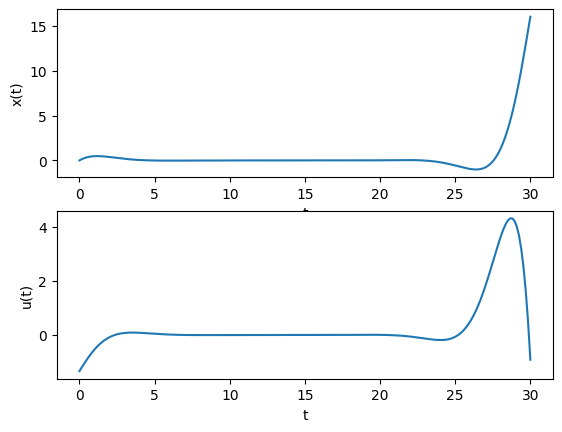

In [10]:
def prob1():
    '''
    Find the optimal path for the fixed time horizon problem
    '''    
    # (22.6)
    def ode(t, y):
        y_prime = np.array([y[1],
                        (5/(4*np.pi))*y[3],
                        2*y[0],
                        -y[2]])
        return y_prime
    
    # Boundary conditions
    def bc(ya, yb):
        return np.array([ya[0], ya[1]-1, yb[0]-16, yb[1]-10])  # y(0) = 0, y(pi/2) = 1
    
    # Set up line space and initial guess
    ts = np.linspace(0, 30, 200)
    y_guess = np.zeros((4, ts.size))
    
    # Solve the BVP
    sol = solve_bvp(ode, bc, ts, y_guess)
    x = sol.y[0]
    u = sol.yp[1]
    
    # Plot it
    plt.subplot(211)
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.plot(ts, x)
    plt.subplot(212)
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.plot(ts, u)
    plt.show()
    
    
prob1()
    

## Problem 2 
Using the ODEs found in 14.7 and 14.11, the obstacle function 14.8, and the following boundary conditions and parameters solve for and plot the optimal path.
\begin{align*}
    t_0 = 0 &, \quad t_f = 20\\
    (c_x,c_y) &= (4,1)\\
    (r_x,r_y) &= (5,.5)\\
    \lambda &= 20\\
    s_0 = \begin{bmatrix}6\\1.5\\0\\0 \end{bmatrix}&, \quad s_f = \begin{bmatrix}0\\0\\0\\0 \end{bmatrix}
\end{align*}
You will need to choose a $W_1$ and $W_2$ which allow the solver to find a valid path.
If these parameters are not chosen correctly, the solver may find a path which goes through the obstacle, not around it.
Plot the obstacle using plt.contour() to be certain path doesn't pass through the obstacle. Also plot the initial guess for $x$ and $y$ provided to solve_bvp

In [3]:
def obstacle(x, y, W1=1, r=(1, 1), c=(0, 0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

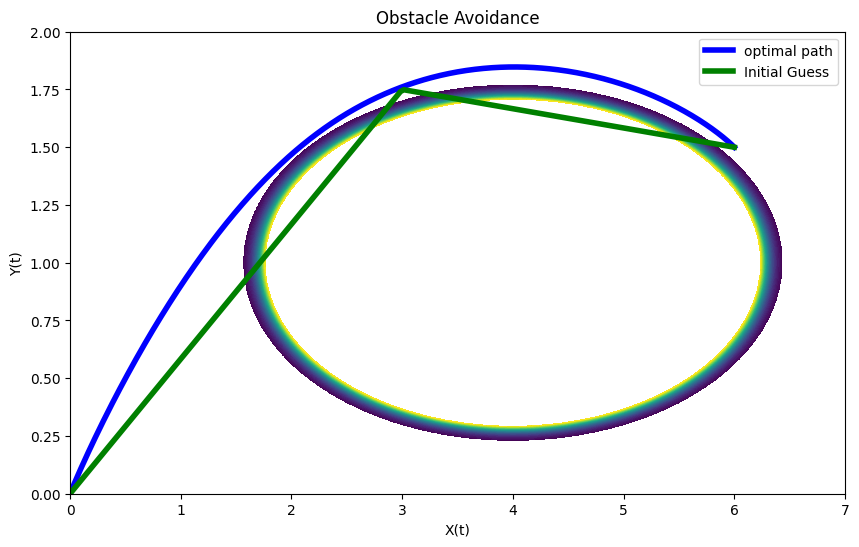

In [50]:
def prob2():
    '''
    Find the optimal path for the fixed time horizon problem
    '''
    # Given parameters
    t0, tf = 0, 20
    cx, cy = 4, 1
    rx, ry = 5, .5
    
    # Choose certain values of W_1 and W_2
    W_1, W_2 = 3, 70
    
    # Set up the ODE
    def ode(x, y):
        s1, s2, s3, s4, p1, p2, p3, p4 = y
        y_prime = np.array([s3,
                            s4,
                            (1/(2*W_2))*p3,
                            (1/(2*W_2))*p4,
                            obstacle_dx(s1, s2, W1=W_1, r=(rx, ry,), c=(cx, cy)),
                            obstacle_dy(s1, s2, W1=W_1, r=(rx, ry,), c=(cx, cy)),
                            -p1,
                            -p2])
        return y_prime
    
    # Define the boundary condition
    def bc(ya, yb):
        s0_1, s0_2, s0_3, s0_4 = ya[:4]
        s1_1, s1_2, s1_3, s1_4 = yb[:4]
        return np.array([s0_1 - 6, s0_2 - 1.5, s0_3, s0_4,
                        s1_1, s1_2, s1_3, s1_4])
        
    # Create t line space
    t_steps = 200
    ts = np.linspace(t0, tf, t_steps)
    
    # Make initial guess
    y0 = np.ones((8, t_steps))
    x = np.linspace(0, 6, t_steps)
    y1 = (1.75 / 3) * x[:int(t_steps/2)]
    y2 = (1.5 - 1.75) / 3 * (x[int(t_steps/2):] - 3) + 1.75
    y_init = np.concatenate((y1, y2))
    y0[0,:] = x[::-1]
    y0[1,:] = y_init[::-1]
    y0[2,:] = -1*np.ones(t_steps)
    
    # Solve it
    sol = solve_bvp(ode, bc, ts, y0, max_nodes=30000)
    xs = sol.y[0]
    ys = sol.y[1]
    
    # Create a meshgrid
    x_space = np.linspace(0, 7, 2000)
    y_space = np.linspace(0, 2, 2000)
    X, Y = np.meshgrid(x_space, y_space)

    # Compute obstacle function values
    Z = obstacle(X, Y, W1=W_1, r=(rx, ry,), c=(cx, cy))
    # Adjust threshold to control visibility
    Z[Z < 0.1] = np.nan  
    Z[Z > 1.5] = np.nan  
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')

    # Add labels and colorbar
    plt.xlabel("X(t)")
    plt.ylabel("Y(t)")
    plt.title("Obstacle Avoidance")
    
    plt.plot(xs, ys, color="blue", linewidth=4, label="optimal path")
    plt.plot(y0[0], y0[1], linewidth=4, color="green", label="Initial Guess")
    plt.legend()
    plt.show()
    
prob2()

## Problem 3
Solve the following boundary value problem:
\begin{align*}
    y'' + 3y &= \sin(t)\\
    y(0) = 0,\quad y(t_f) = &\frac{\pi}{2}, \quad y'(t_f) = \frac{1}{2}\left(\sqrt{3}\pi \cot(\pi\sqrt{75}) - 1 \right).
\end{align*}
Plot your solution. What $t_f$ did the solver find?

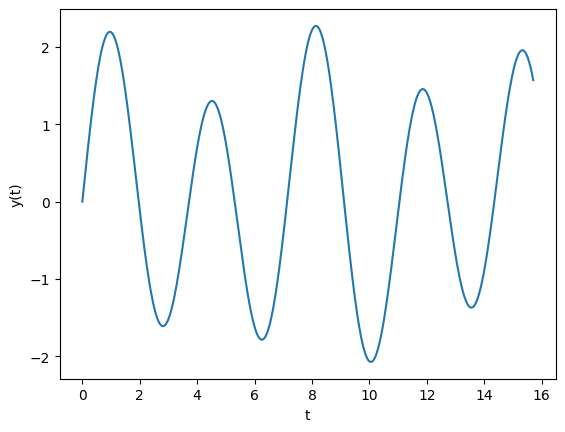

Final value for t: 15.707963336431147


In [26]:
def prob3():
    '''
    Solve the free time horizon BVP.
    Plot the solution and return the correct end time
    '''
    
    def ode(t, y, p):
        return p[0]*np.array([y[1], np.sin(p[0]*t)-3*y[0]])
    
    def bc(ya, yb, p):
        right = yb[1] - .5*(np.sqrt(3)*np.pi*(1/np.tan(np.pi*np.sqrt(75))) - 1)
        return np.array([ya[0], yb[0]-np.pi/2, right])
    
    # Create t line space
    t_steps = 1000
    ts = np.linspace(0, 1, t_steps)
    
    # Initial guess
    y0 = np.ones((2, t_steps))
    
    # Solve it
    sol = solve_bvp(ode, bc, ts, y0, p=np.array([5*np.pi]))
    
    plt.plot(sol.p[0]*ts,sol.sol(ts)[0])
    plt.xlabel('t')
    plt.ylabel("y(t)")
    plt.show()

    print("Final value for t:", sol.p[0])
    

prob3()

## Problem 4
Refactor your code from Problem 2 to create a free end time BVP and use a new boundary value derived from 

$H(t_f,p(t_f),s(t_f),u(t_f)) = 0.$

Let $W_1 = 4$ and $W_2 = 0.1$, and use $6$ as the initial guess for p(0) and max_nodes = 60000.
Plot the solution you found along with the initial guess for $x$ and $y$.
What is the optimal time?

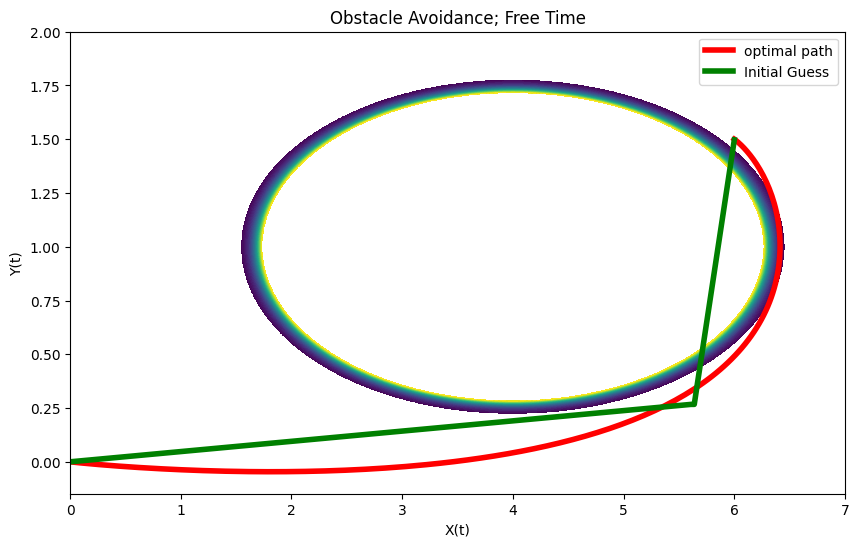

Final value for t: 4.466966643534014


In [16]:
def prob4():
    '''
    Find the optimal path and time for the free time horizon problem.
    Plot the solution along with the initial guess for $x$ and $y$ and return the optimal time.
    '''
    # Given parameters
    t0, tf = 0, 1
    cx, cy = 4, 1
    rx, ry = 5, .5
    
    # Choose certain values of W_1 and W_2
    W_1, W_2 = 4, 0.1
    
    # Set up the ODE
    def ode(x, y, p):
        s1, s2, s3, s4, p1, p2, p3, p4 = y
        y_prime = p[0] * np.array([s3,
                            s4,
                            (1/(2*W_2))*p3,
                            (1/(2*W_2))*p4,
                            obstacle_dx(s1, s2, W1=W_1, r=(rx, ry,), c=(cx, cy)),
                            obstacle_dy(s1, s2, W1=W_1, r=(rx, ry,), c=(cx, cy)),
                            -p1,
                            -p2])
        return y_prime
    
    # Define the boundary condition
    def bc(ya, yb, p):
        s0_1, s0_2, s0_3, s0_4, p0_1, p0_2, p0_3, p0_4 = ya
        s1_1, s1_2, s1_3, s1_4, p1_1, p1_2, p1_3, p1_4 = yb 
        
        # Hamiltonian is zero at the endpoint
        u1 = 1/(2*W_2)*yb[6]
        u2 = 1/(2*W_2)*yb[7]
        C = obstacle(s1_1, s1_2, W1=W_1, r=(rx, ry), c=(cx, cy))
        W_term = W_2 * (u1**2 + u2**2)
        H_tf = p1_1*s1_3 + p1_2*s1_4 + p1_3*u1 + p1_4*u2 - (1 + C + W_term)

        return np.array([s0_1 - 6, s0_2 - 1.5, s0_3, s0_4,
                        s1_1, s1_2, s1_3, s1_4, H_tf])
        
    # Create t line space
    t_steps = 200
    ts = np.linspace(t0, tf, t_steps)
    
    # # Make initial guess
    y0 = np.ones((8, t_steps))
    x = np.linspace(0, 6, t_steps)
    y1 = (1 / 21) * x[:int(15*t_steps/16)]
    y2 = 3.4*(x[int(15*t_steps/16):] - x[int(15*t_steps/16)]) + y1[-1]
    y_init = np.concatenate((y1, y2))
    y0[0,:] = x[::-1]
    y0[1,:] = y_init[::-1]
    y0[2,:] = -1*np.ones(t_steps)
    
    # Solve it
    sol = solve_bvp(ode, bc, ts, y0, p=np.array([6]), max_nodes=60000)
    ts, solution = sol.p[0]*ts, sol.sol(ts)
    xs, ys = solution[0], solution[1]
        
    # Create a meshgrid
    x_space = np.linspace(0, 7, 2000)
    y_space = np.linspace(0, 2, 2000)
    X, Y = np.meshgrid(x_space, y_space)

    # Compute obstacle function values
    Z = obstacle(X, Y, W1=W_1, r=(rx, ry,), c=(cx, cy))
    # Adjust threshold to control visibility
    Z[Z < 0.1] = np.nan  
    Z[Z > 1.5] = np.nan  
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')

    # Add labels and colorbar
    plt.xlabel("X(t)")
    plt.ylabel("Y(t)")
    plt.title("Obstacle Avoidance; Free Time")
    
    plt.plot(xs, ys, color="red", linewidth=4, label="optimal path")
    plt.plot(y0[0], y0[1], linewidth=4, color="green", label="Initial Guess")
    plt.legend()
    plt.show()
    
    print("Final value for t:", sol.p[0])
    
prob4()